<a href="https://colab.research.google.com/github/karrin10/Introduction-to-Deep-Learning/blob/Homework-1/HW1_Problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, StandardScaler
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [10]:
# Set the device if the gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the data
df =  pd.read_csv('https://raw.githubusercontent.com/karrin10/Introduction-to-Deep-Learning/Homework-1/house-train.csv')
selected_cols = ['OverallQual','GrLivArea','GarageArea',
                 'TotalBsmtSF','FullBath','YearBuilt',
                 'YearRemodAdd','Fireplaces','LotFrontage',
                 'WoodDeckSF','OpenPorchSF','ExterQual',
                 'Neighborhood','MSZoning','Alley',
                 'LotShape','LandContour','Condition1',
                 'HouseStyle','MasVnrType','SaleCondition',
                 'SalePrice']
df1 =  df[selected_cols].copy()

Total Training Time: 0.12 seconds
Epoch 1/75, Training Loss: 38587874121.64384 , Validation Loss:  37651843380.60274 , Validation RMSE:   194040.82915871788
Total Training Time: 0.25 seconds
Epoch 2/75, Training Loss: 24223196636.931507 , Validation Loss:  5683559224.109589 , Validation RMSE:   75389.38402792258
Total Training Time: 0.38 seconds
Epoch 3/75, Training Loss: 6113460364.2739725 , Validation Loss:  4708545644.712329 , Validation RMSE:   68618.84321898999
Total Training Time: 0.53 seconds
Epoch 4/75, Training Loss: 4346846502.575342 , Validation Loss:  3167730421.479452 , Validation RMSE:   56282.59430302989
Total Training Time: 0.68 seconds
Epoch 5/75, Training Loss: 3123437136.657534 , Validation Loss:  2430244375.6712327 , Validation RMSE:   49297.50881810594
Total Training Time: 0.79 seconds
Epoch 6/75, Training Loss: 2394151546.739726 , Validation Loss:  1755929960.328767 , Validation RMSE:   41903.81796839958
Total Training Time: 0.90 seconds
Epoch 7/75, Training Loss:

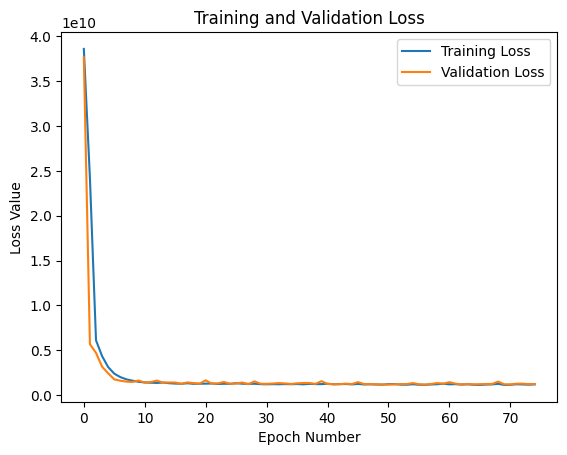

In [4]:
# Problem 2A - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
features = df1.drop(['SalePrice'], axis=1)
targets = df1['SalePrice'].values.reshape(-1, 1)

# Convert all values to numbers then declare them as 0s
features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
features = StandardScaler().fit_transform(features)

# Split the data into train sets
x_train, x_val, y_train, y_val = train_test_split(features, targets, test_size=0.2, random_state=42)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

# Split the data into validation sets
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Create TensorDatasets and DataLoaders for train and validation sets
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_val, y_val)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)

# Model definition
class RegressionNet(nn.Module):
    def __init__(self, input):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(input, 248)
        self.fc2 = nn.Linear(248, 64)
        self.fc3 = nn.Linear(64, 8)
        self.fc4 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = RegressionNet(input=x_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 75
training_losses = []
validation_losses = []
total_start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate training loss
        running_loss += loss.item() * inputs.size(0)

    # Calculate training time
    end_time = time.time()
    training_time = end_time - start_time

    running_loss /= len(train_loader.dataset)
    training_losses.append(running_loss)

    # Total training time
    total_end_time = time.time()
    total_training_time = total_end_time - total_start_time
    print(f'Total Training Time: {total_training_time:.2f} seconds')

    # Testing the model
    model.eval()
    val_loss = 0.0
    val_total = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_total += ((outputs - labels) ** 2).sum().item()

    # Update validation loss
    val_loss /= len(validation_loader.dataset)
    validation_losses.append(val_loss)
    rmse = np.sqrt(val_total / len(validation_loader.dataset))

    # Training statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss} , Validation Loss:  {val_loss} , Validation RMSE:   {rmse}')


print(f'Final Training Loss: {training_losses[-1]}')
print(f'Final Validation Loss: {validation_losses[-1]}')
print(f'Final Validation RMSE: {rmse}')
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss Value')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Total Training Time: 0.10 seconds
Epoch 1/75, Training Loss: 38430892845.58904 , Validation Loss:  36746795120.21918 , Validation RMSE:   191694.53596860598
Total Training Time: 0.20 seconds
Epoch 2/75, Training Loss: 22026839418.739727 , Validation Loss:  7866765157.69863 , Validation RMSE:   88694.78653054322
Total Training Time: 0.29 seconds
Epoch 3/75, Training Loss: 5225287395.945206 , Validation Loss:  2800225251.9452057 , Validation RMSE:   52917.1546093061
Total Training Time: 0.40 seconds
Epoch 4/75, Training Loss: 2536792165.6986303 , Validation Loss:  2258385793.7534246 , Validation RMSE:   47522.476721583276
Total Training Time: 0.51 seconds
Epoch 5/75, Training Loss: 1878812544.0 , Validation Loss:  1911332004.8219178 , Validation RMSE:   43718.78320381204
Total Training Time: 0.60 seconds
Epoch 6/75, Training Loss: 1528675711.1232877 , Validation Loss:  1751092535.2328768 , Validation RMSE:   41846.057582917856
Total Training Time: 0.73 seconds
Epoch 7/75, Training Loss: 

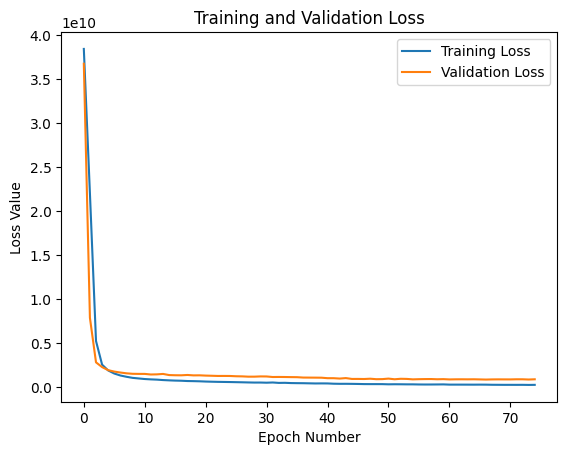

In [5]:
# Problem 2B - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# One hot encoding
encoded_columns = ['Neighborhood','MSZoning','Alley','LotShape','LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition']
df1 = pd.get_dummies(df1, columns=encoded_columns)
df1 = df1.replace({True: 1, False: 0})

# Separate features and targets
features = df1.drop(['SalePrice'], axis=1)
targets = df1['SalePrice'].values.reshape(-1, 1)

# Convert all values to numbers and declare them as 0s
features = features.apply(pd.to_numeric, errors='coerce').fillna(0)

# Standardize the features
features = StandardScaler().fit_transform(features)

# Split the data into train sets
x_train, x_val, y_train, y_val = train_test_split(features, targets, test_size=0.2, random_state=42)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

# Split the data into validation sets
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Create TensorDatasets and DataLoaders for train and validation sets
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_val, y_val)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)

# Model definition
class RegressionNet(nn.Module):
    def __init__(self, input):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(input, 248)  # 21 inputs
        self.fc2 = nn.Linear(248, 64)
        self.fc3 = nn.Linear(64, 8)
        self.fc4 = nn.Linear(8, 1)  # 1 output

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = RegressionNet(input=x_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 75
training_losses = []
validation_losses = []
total_start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate training loss
        running_loss += loss.item() * inputs.size(0)

    # Calculate training time
    end_time = time.time()
    training_time = end_time - start_time

    running_loss /= len(train_loader.dataset)
    training_losses.append(running_loss)

    # Total training time
    total_end_time = time.time()
    total_training_time = total_end_time - total_start_time
    print(f'Total Training Time: {total_training_time:.2f} seconds')

    # Testing the model
    model.eval()
    val_loss = 0.0
    val_total = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_total += ((outputs - labels) ** 2).sum().item()

    # Update validation loss
    val_loss /= len(validation_loader.dataset)
    validation_losses.append(val_loss)
    rmse = np.sqrt(val_total / len(validation_loader.dataset))

    # Training statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss} , Validation Loss:  {val_loss} , Validation RMSE:   {rmse}')


print(f'Final Training Loss: {training_losses[-1]}')
print(f'Final Validation Loss: {validation_losses[-1]}')
print(f'Final Validation RMSE: {rmse}')
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss Value')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Total Training Time: 0.18 seconds
Epoch 1/75, Training Loss: 23851039132.054794 , Validation Loss:  2334506261.0410957 , Validation RMSE:   48316.72858380517
Total Training Time: 0.35 seconds
Epoch 2/75, Training Loss: 2397190624.4383564 , Validation Loss:  1378973073.9726028 , Validation RMSE:   37134.52670995825
Total Training Time: 0.53 seconds
Epoch 3/75, Training Loss: 1301560723.2876713 , Validation Loss:  1308977850.739726 , Validation RMSE:   36179.79893172053
Total Training Time: 0.71 seconds
Epoch 4/75, Training Loss: 853124538.7397261 , Validation Loss:  1121434656.6027398 , Validation RMSE:   33487.828484432066
Total Training Time: 0.89 seconds
Epoch 5/75, Training Loss: 732966818.1917808 , Validation Loss:  1150968596.328767 , Validation RMSE:   33925.92808352879
Total Training Time: 1.07 seconds
Epoch 6/75, Training Loss: 690036935.0136986 , Validation Loss:  1153787536.4383562 , Validation RMSE:   33967.448188498885
Total Training Time: 1.24 seconds
Epoch 7/75, Training 

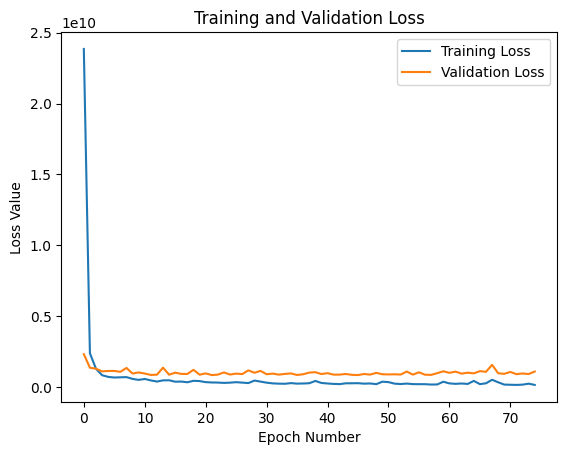

In [6]:
# Problem 2C - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  - - -
df2 =  df[selected_cols].copy()

# One hot encoding
encoded_columns = ['Neighborhood','MSZoning','Alley','LotShape','LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition']
df2 = pd.get_dummies(df2, columns=encoded_columns)
df2 = df2.replace({True: 1, False: 0})

# Separate features and targets
features = df2.drop(['SalePrice'], axis=1)
targets = df2['SalePrice'].values.reshape(-1, 1)

# Convert all values to numbers and declare them as 0s
features = features.apply(pd.to_numeric, errors='coerce').fillna(0)

# Standardize the features
features = StandardScaler().fit_transform(features)

# Split the data into train sets
x_train, x_val, y_train, y_val = train_test_split(features, targets, test_size=0.2, random_state=42)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

# Split the data into validation sets
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Create TensorDatasets and DataLoaders for train and validation sets
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_val, y_val)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)

# Model definition
class RegressionNet(nn.Module):
    def __init__(self, input):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(input, 512)  # Increase width
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)    # 1 output

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

model = RegressionNet(input=x_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 75
training_losses = []
validation_losses = []
total_start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate training loss
        running_loss += loss.item() * inputs.size(0)

    # Calculate training time
    end_time = time.time()
    training_time = end_time - start_time

    running_loss /= len(train_loader.dataset)
    training_losses.append(running_loss)

    # Total training time
    total_end_time = time.time()
    total_training_time = total_end_time - total_start_time
    print(f'Total Training Time: {total_training_time:.2f} seconds')

    # Testing the model
    model.eval()
    val_loss = 0.0
    val_total = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_total += ((outputs - labels) ** 2).sum().item()

    # Update validation loss
    val_loss /= len(validation_loader.dataset)
    validation_losses.append(val_loss)
    rmse = np.sqrt(val_total / len(validation_loader.dataset))

    # Training statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss} , Validation Loss:  {val_loss} , Validation RMSE:   {rmse}')


print(f'Final Training Loss: {training_losses[-1]}')
print(f'Final Validation Loss: {validation_losses[-1]}')
print(f'Final Validation RMSE: {rmse}')
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss Value')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()